<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Оценка-и-тестирование-модели" data-toc-modified-id="Оценка-и-тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценка и тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

В данном проекте будет дополнительно использоваться модель Prophet, поэтому установим необходимую библиотеку

In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


Импортируем библиотеки

In [2]:
import os
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from prophet import Prophet

Загрузим датафрейм как для классических моделей, так и для модели Prophet, т.к. модель Prophet принимает датафрейм только определенного вида

In [3]:
pth = '/datasets/taxi.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth, index_col=[0], parse_dates=[0])
    data_prophet = pd.read_csv(pth)
else:
    print('Something is wrong')

Выведем первые 5 строчек датафрейма

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выполним ресемплирование по одному часу и выведем первые 5 строчек датафрейма

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проведем подготовку датафрейма для модели prophet. Также выполним ресемплирование по одному часу и переименуем столбцы в соответствии с требованием модели  

In [6]:
data_prophet['datetime'] = pd.to_datetime(data_prophet['datetime'])
data_prophet = data_prophet.set_index('datetime')
data_prophet = data_prophet.resample('h').sum()
data_prophet = data_prophet.reset_index()
data_prophet = data_prophet.rename(columns={'datetime': 'ds', 'num_orders': 'y'})

В пункте “Подготовка” были загружены 2 одинаковых датафрейма для классических моделей и для модели Prophet. Для обоих датафреймов было произведено ресемплирование по одному часу. Датафрейм для модели Prophet был изменен в соответствии с определенными требованиями модели для ее обучения и предсказания. 

## Анализ

Для анализа  “сгладим” временной ряд, для того чтобы увидеть закономерности и построим график временного ряда 

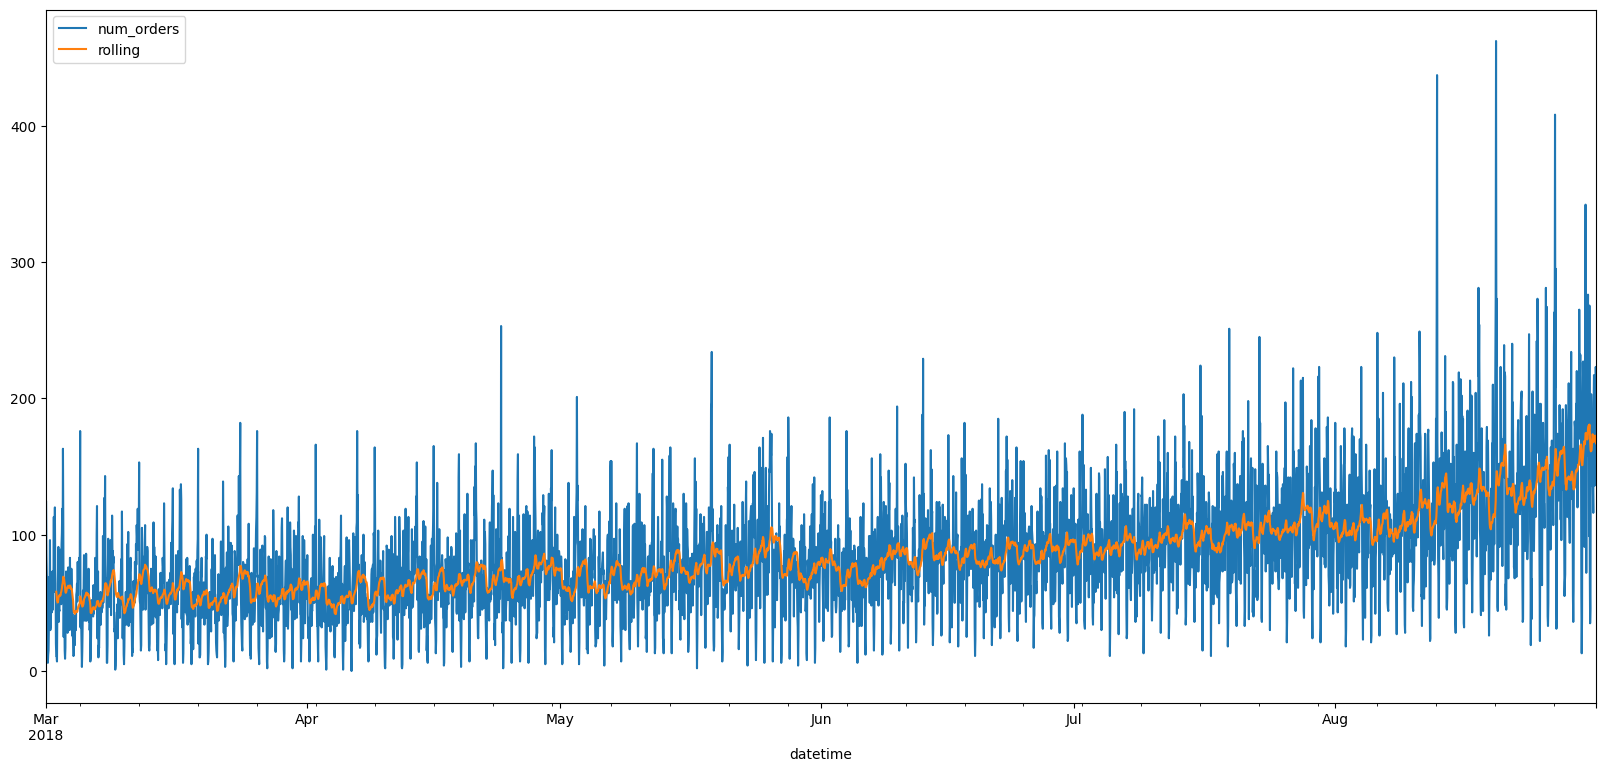

In [7]:
data_copy = data.copy()
data_copy['rolling'] = data_copy.rolling(30).mean()
data_copy.plot(figsize=(20,9));

На графике можно увидеть тренд увеличения заказов такси. Тренд — плавное изменение среднего значения ряда без повторяющихся закономерностей. В нашем случае заказы такси увеличиваются с каждым месяцем. Также можно заметить на графике сезонность. Сезонность — циклично повторяющиеся закономерности во временном ряду. 

Разложим на отдельные графики тренд и сезонность 

Построим график для тренда  

In [8]:
decomposed = seasonal_decompose(data)

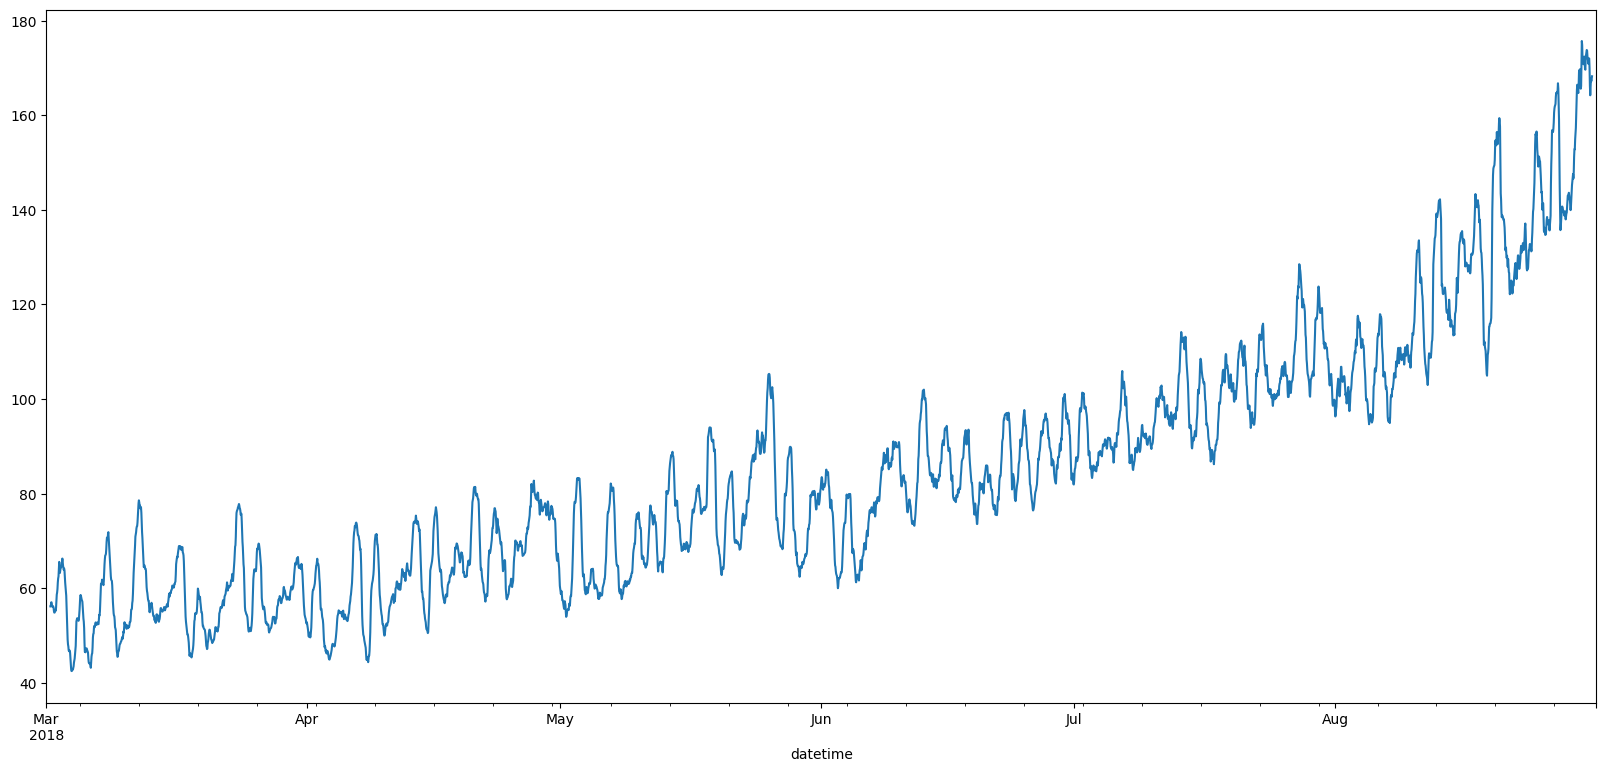

In [9]:
decomposed.trend.plot(figsize=(20,9));

По графику можно сделать вывод о том, что количество заказов такси увеличиваются с каждым месяцем.

Построим график для сезонности  

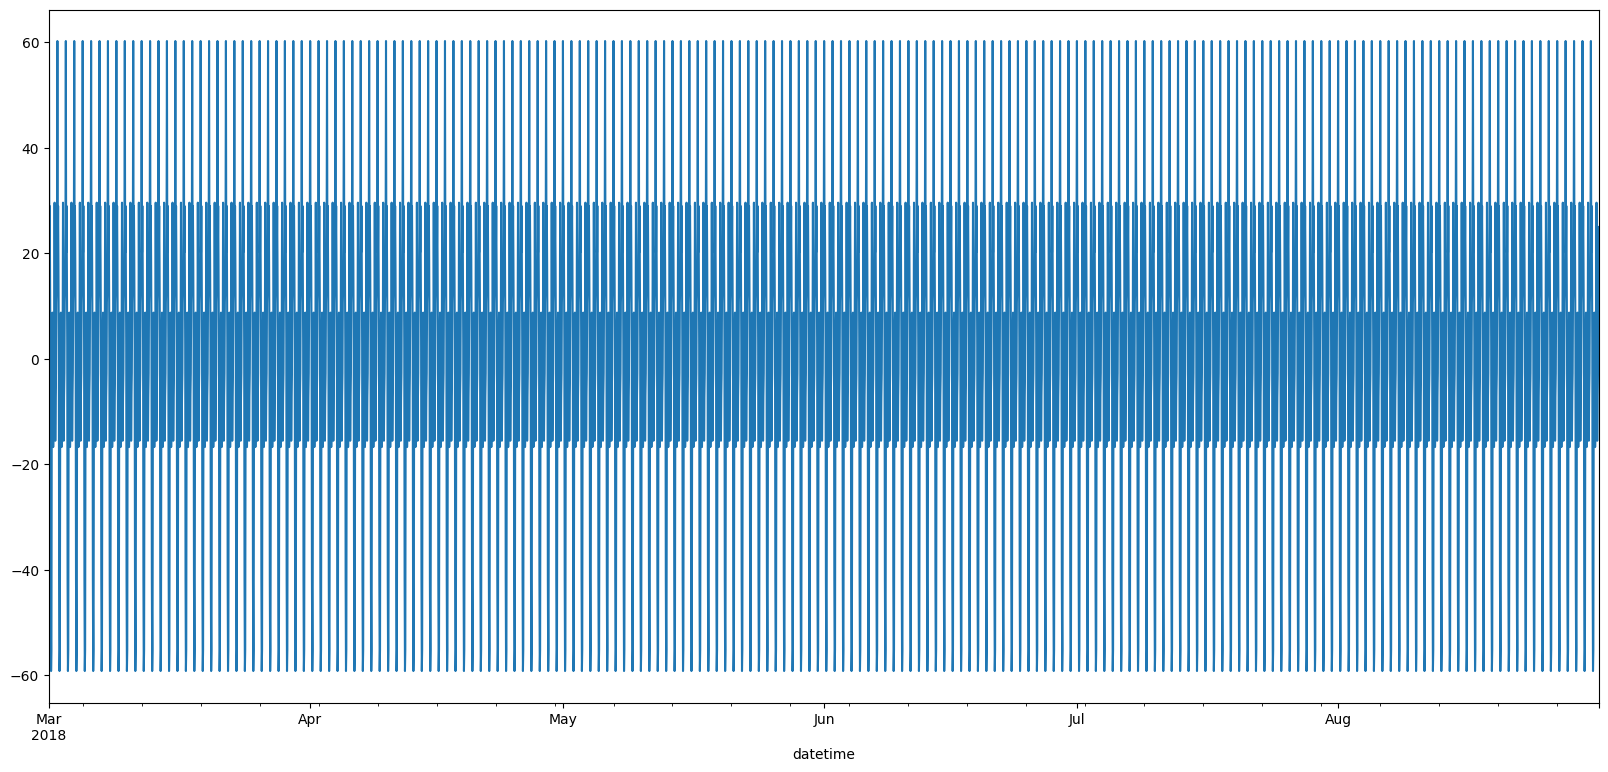

In [10]:
decomposed.seasonal.plot(figsize=(20,9));

В масштабе всего датасета трудно увидеть зависимость, уменьшим масштаб до одной недели    

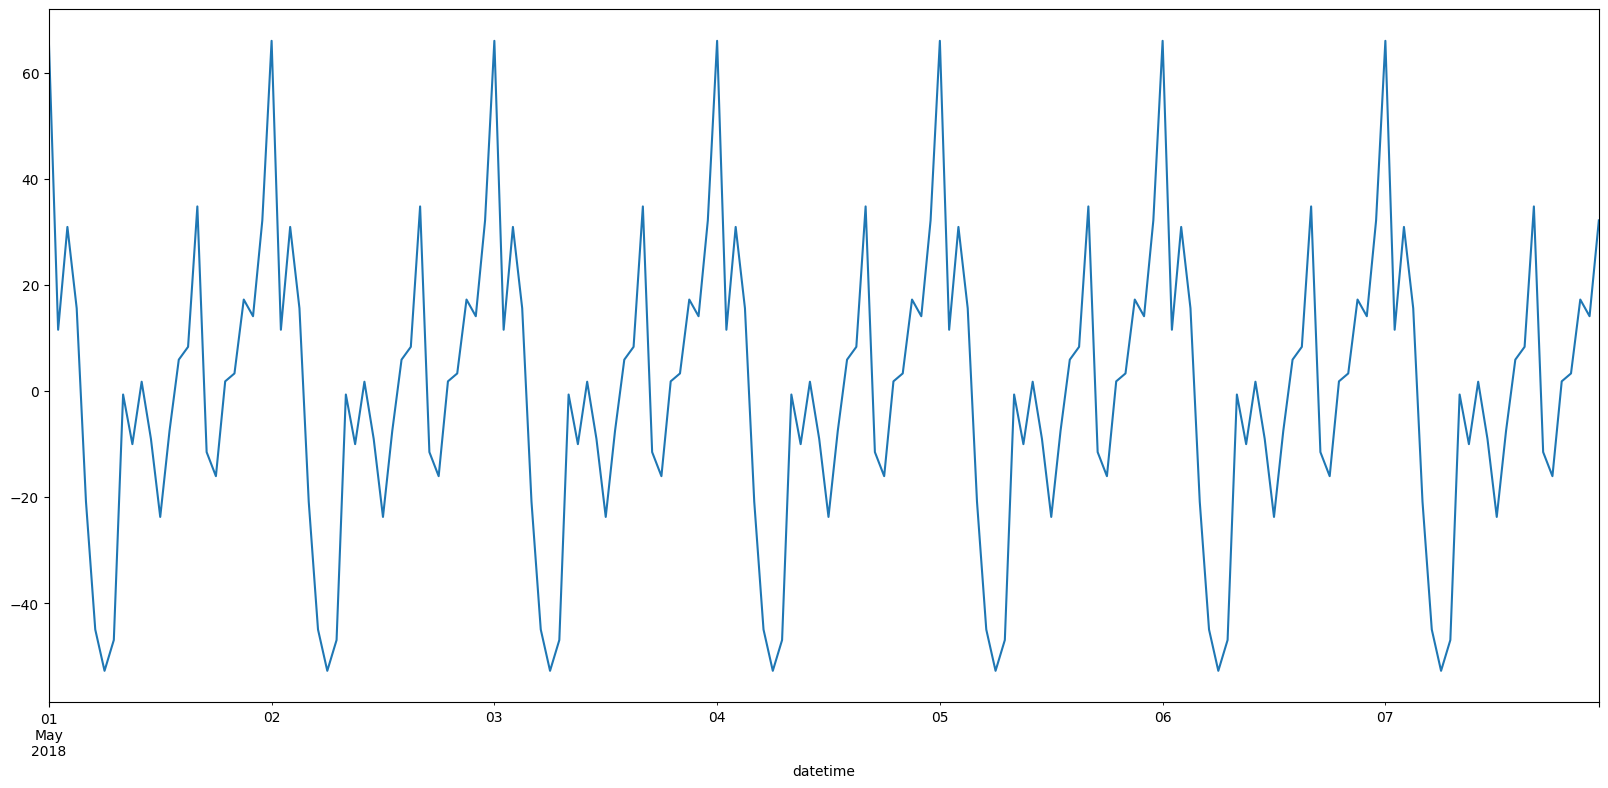

In [11]:
data_copy = data['2018-05-01':'2018-05-07']
decomposed = seasonal_decompose(data_copy)
decomposed.seasonal.plot(figsize=(20,9));

По графику можно сделать вывод о том, что наибольшее количество заказов приходится на конец дня 

В пункте “Анализ” были построены 3 графика для временного ряда, тренда и сезонности. График временного ряда дал понимание того, что в датасете присутствует и тренд и сезонность.  График тренда показал что количество заказов увеличивается что временем, а график тренда показал что наибольшее количество заказов приходится на конец дня. 

## Обучение

Создадим функцию для создания фичей временного ряда 

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


Создадим функцию для вычисления RMSE  

In [13]:
def rmse_func(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

Применим функцию для создания фичей временного ряда к нашему датафрейму и разобьем датафрейм на тренировочную и тестовую выборку  

In [14]:
make_features(data, 20, 30)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
train.shape, test.shape

((3944, 25), (442, 25))

Разобьем тренировочную и тестовую выборку на выборки с целевыми и таргетными признаками 

In [15]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Обучим модель линейной регрессии и вычислим RMSE c помощью кросс валидации

In [16]:
model_linear = LinearRegression()
tscv = TimeSeriesSplit()
cvs_linear = cross_val_score(model_linear, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
print(f'RMSE линейной регрессии: {cvs_linear*(-1)}')

RMSE линейной регрессии: 30.780246203012588


Обучим модель градиентного бустинга и вычислим RMSE c помощью кросс валидации

In [17]:
parameters = {'iterations':range(1000, 3001, 200), 'learning_rate':[0.01, 0.03, 0.1]}
model_catboost = CatBoostRegressor(random_state=12345)
gscv_catboost = GridSearchCV(estimator=model_catboost,param_grid=parameters,scoring='neg_root_mean_squared_error',cv=tscv)
gscv_catboost.fit(features_train, target_train, verbose=False)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000016DB45A62E0>,
             param_grid={'iterations': range(1000, 3001, 200),
                         'learning_rate': [0.01, 0.03, 0.1]},
             scoring='neg_root_mean_squared_error')

In [18]:
print(f'RMSE модели градиентного бустинга: {gscv_catboost.best_score_*(-1)}\nЛучшие параметры: {gscv_catboost.best_params_}')

RMSE модели градиентного бустинга: 24.999378065456277
Лучшие параметры: {'iterations': 2000, 'learning_rate': 0.03}


Разобьем датафрейм для модели prophet на тренировочную,валидационную и тестовую выборку. Разбивать получившиеся выборки на таргетную и целевую выборку не требуется

In [19]:
train_prophet, test_prophet = train_test_split(data_prophet, shuffle=False, test_size=0.1)
train_prophet, valid_prophet = train_test_split(train_prophet, shuffle=False, test_size=0.111)
train_prophet.shape,valid_prophet.shape, test_prophet.shape

((3532, 2), (442, 2), (442, 2))

Запишем размер наших выборок 

In [20]:
train_prophet_shape = 3532
valid_prophet_shape = 442

Обучим модель prophet 

In [21]:
model = Prophet()
model.fit(train_prophet)
future = model.make_future_dataframe(periods=valid_prophet_shape, freq='H')
forecast = model.predict(future)

17:09:57 - cmdstanpy - INFO - Chain [1] start processing
17:09:57 - cmdstanpy - INFO - Chain [1] done processing


Посмотрим на датафрейм с получившимся фичами и посчитаем RMSE модели  

In [22]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-01 00:00:00,54.349713,56.668500,117.824679,54.349713,54.349713,32.989723,32.989723,32.989723,30.401543,30.401543,30.401543,2.588180,2.588180,2.588180,0.0,0.0,0.0,87.339436
1,2018-03-01 01:00:00,54.356162,55.519021,116.299628,54.356162,54.356162,32.173283,32.173283,32.173283,30.048866,30.048866,30.048866,2.124417,2.124417,2.124417,0.0,0.0,0.0,86.529444
2,2018-03-01 02:00:00,54.362610,53.209789,111.122693,54.362610,54.362610,27.644655,27.644655,27.644655,26.010829,26.010829,26.010829,1.633826,1.633826,1.633826,0.0,0.0,0.0,82.007265
3,2018-03-01 03:00:00,54.369059,38.816026,98.855105,54.369059,54.369059,13.649909,13.649909,13.649909,12.524278,12.524278,12.524278,1.125632,1.125632,1.125632,0.0,0.0,0.0,68.018968
4,2018-03-01 04:00:00,54.375507,13.552748,72.197454,54.375507,54.375507,-11.001068,-11.001068,-11.001068,-11.610343,-11.610343,-11.610343,0.609275,0.609275,0.609275,0.0,0.0,0.0,43.374439


In [23]:
pro_rmse = rmse_func(valid_prophet.y, forecast.loc[train_prophet_shape:, 'yhat'].values)
print(f'RMSE модели Prophet: {pro_rmse}')

RMSE модели Prophet: 33.72893958511752


Сделаем фичи Prophet'a для всего датасета 

In [24]:
train_prophet = pd.concat([train_prophet] + [valid_prophet])
train_prophet.shape

(3974, 2)

In [25]:
train_prophet_shape = 3974

In [26]:
model = Prophet()
model.fit(train_prophet)
future = model.make_future_dataframe(periods=valid_prophet_shape, freq='H')
forecast = model.predict(future)


17:09:58 - cmdstanpy - INFO - Chain [1] start processing
17:09:58 - cmdstanpy - INFO - Chain [1] done processing


Цель добавление модели Prophet в проект было обучение модели градиентного бустинга catboost на фичах полученных от модели Prophet и сгенерированных фичей функции make_features. Создадим общий датафрейм со всеми фичами, разобьем датафрейм на выборки и обучим модель градиентного бустинга 

In [27]:
data_prophet_cb = forecast.copy()
data_prophet_cb = data_prophet_cb.set_index('ds')
data_prophet_cb = data_prophet_cb.join(data)
train, test = train_test_split(data_prophet_cb, shuffle=False, test_size=0.1)
train = train.dropna()

In [28]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [29]:
model_catboost_prophet = CatBoostRegressor(random_state=12345)
gscv_catboost_prophet = GridSearchCV(estimator=model_catboost_prophet,
                                     param_grid=parameters,
                                     scoring='neg_root_mean_squared_error',
                                     cv=tscv)
gscv_catboost_prophet.fit(features_train, target_train, verbose=False)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000016DB44086A0>,
             param_grid={'iterations': range(1000, 3001, 200),
                         'learning_rate': [0.01, 0.03, 0.1]},
             scoring='neg_root_mean_squared_error')

In [30]:
print(f'RMSE модели градиентного бустинга основанная на моделе Prophet: {gscv_catboost_prophet.best_score_*(-1)}\n\
Лучшие параметры: {gscv_catboost_prophet.best_params_}')

RMSE модели градиентного бустинга основанная на моделе Prophet: 23.202671734280933
Лучшие параметры: {'iterations': 2400, 'learning_rate': 0.01}


Значение метрики RMSE на тестовой выборке должно быть не больше 48. Посмотрим на получившиеся значения наших моделей:

- Линейная регрессия – 30.78 - *меньше порогового значения*
- Градиентный бустинг CatBoost – 25.00 - *меньше порогового значения*
- Модель Prophet – 33.73 - *меньше порогового значения*
- Модель Prophet + Градиентный бустинг CatBoost – 23.20 - *меньше порогового значения*

Лучше значение показала модель градиентного бустинга, обученная на кастомных фичах + фичи от Prophet’а. Ее и возьмем для финального тестирования.


## Оценка и тестирование модели

Протестируем лучшую модель

In [31]:
best_model = gscv_catboost_prophet.best_estimator_
best_model.fit(features_train, target_train, verbose=False)
predict_test = best_model.predict(features_test)
best_rmse = rmse_func(target_test, predict_test)

In [32]:
print(f'RMSE лучшей модели градиентного бустинга основанная на моделе Prophet: {best_rmse}')

RMSE лучшей модели градиентного бустинга основанная на моделе Prophet: 39.48837088905724


Оценим адекватность полученной модели, для этого сравним ее с dummy-моделью 

In [33]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)
predict = dummy_model.predict(features_test)
rmse_dummy = rmse_func(target_test, predict)
print(f'RMSE dummy-модели: {rmse_dummy}')

RMSE dummy-модели: 84.63336276399527


In [34]:
print(f'Разница между RMSE dummy-модели и RMSE модели градиентного бустинга: {rmse_dummy - best_rmse}')

Разница между RMSE dummy-модели и RMSE модели градиентного бустинга: 45.14499187493803


Значение не отрицательное, а это значит, что использование модели градиентного бустинга оправдано

Визуализируем результаты предсказания модели и тестовые данные

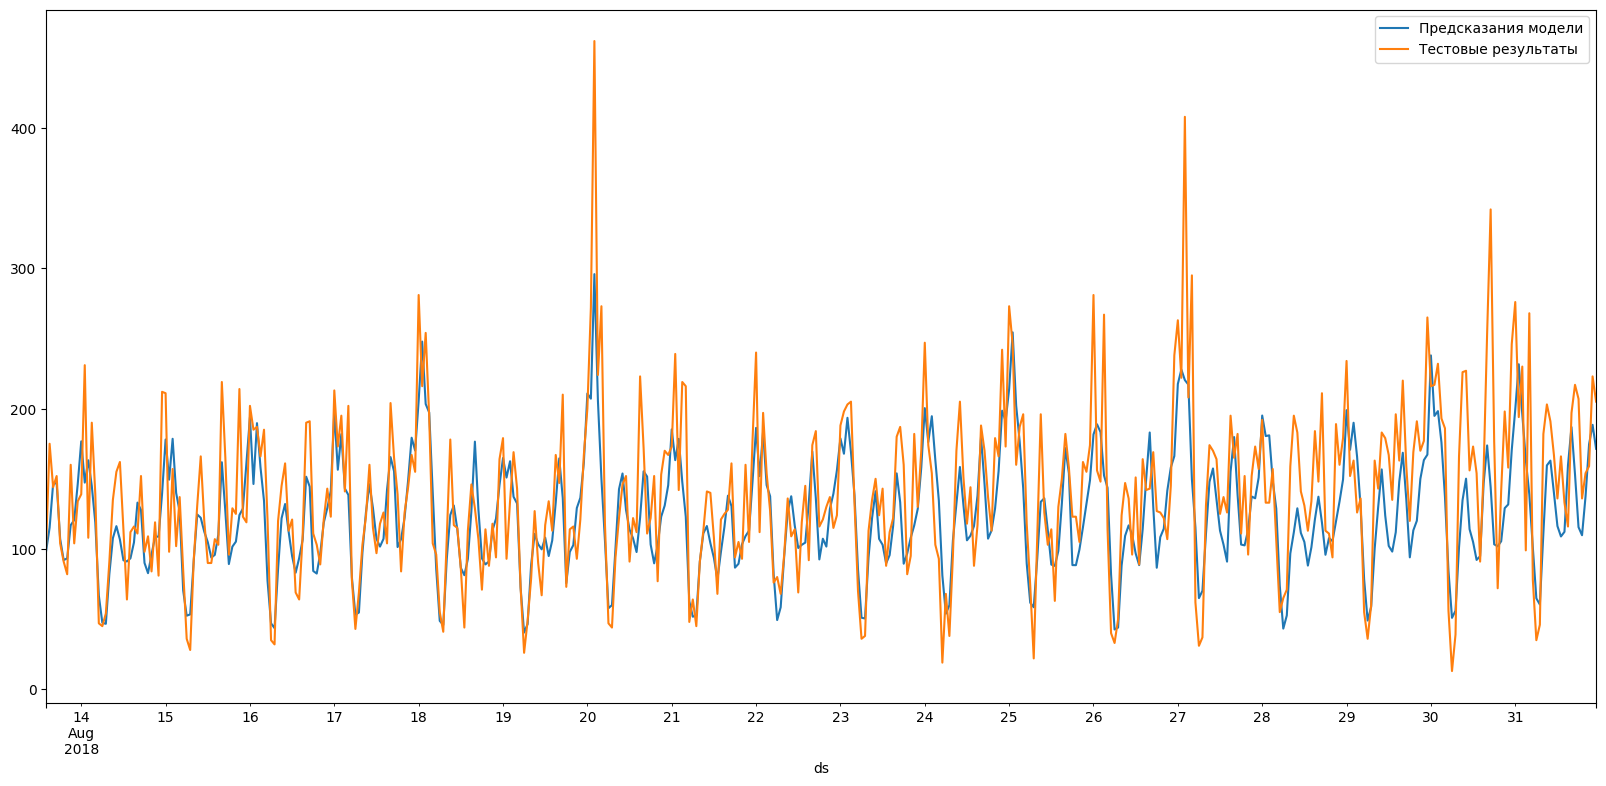

In [35]:
predict_df = pd.DataFrame(predict_test, index=target_test.index)
predict_df.join(target_test).rename(columns={0:'Предсказания модели', 'num_orders':'Тестовые результаты'}).plot(figsize=(20,9));

## Вывод

В пункте “Подготовка” были загружены 2 одинаковых датафрейма для классических моделей и для модели Prophet. Для обоих датафреймов было произведено ресемплирование по одному часу. Датафрейм для модели Prophet был изменен в соответствии с определенными требованиями: Для обучения необходимо чтобы в датафрейме было только 2 колонки с временем и таргетным признаком, также колонки должны иметь определенное название: для временного ряда – ds, для таргетного признака - y.

В пункте “Анализ” был построен график для временного ряда, а также было произведено его сглаживание для определения таких зависимостей как тренд и сезонность. График показал тренд увеличения заказов такси со временем, а также показал сезонность в зоависимости от времени суток. 

В пункте “Обучение” были подготовлены признаки и выборки для обучения моделей. Обучены 4 модели:

- Линейная регрессия обученная на кастомных фичах с результатом RMSE – 30.78
- Градиентный бустинг CatBoost обученный на кастомных фичах с результатом RMSE – 25.00
- Модель Prophet обученная на своих сформированных фичах с результатом RMSE – 33.73
- Градиентный бустинг CatBoost обученный на кастомных фичах и фичах сформированных моделью Prophet с результатом RMSE – 23.26

Поскольку результат не должен быть выше порогового значения RMSE – 48, для оценки подходят все модели. Сравнивая  различные модели однозначно выигрывает градиентный бустинг CatBoost обученный на кастомных фичах и фичах сформированных моделью Prophet, так как его результат лучше всех остальных. 

В пункте “Оценка и тестирование модели” была протестирована лучшая модель на тестовой выборке и было проведено сравнение с dummy-моделю. RMSE бустинга лучше RMSE dummy-модели на 45.14, использование модели градиентного бустинга можно считать оправданным.
